# Ejercicio 2: "Analizando nuestro modelo" (obligatorio)

Usando como base alguno de los dos ejemplos realizar código que:
1. Calcule la matriz de confusión para los dígitos. La matriz de confusión es una métrica, por lo que debe ser calculada sólo en validación.
2. Utilizando la matriz de confusión elegir el par de dígitos dónde el modelo se confunde más y mostrar 20 ejemplos mal clasificados.
3. Una función que muestre los 20 ejemplos de validación con mayor costo. Intuitivamente estos son los ejemplos donde el modelo está más errado: arroja probabilidades altas para clases que no son la correcta.
4. Una función que muestre los 20 ejemplos de validación donde el modelo arroja probabilidades más bajas. Esto se puede interpretar como que el modelo está "poco seguro" para estos casos.

Todo este trabajo de visualización suele ser comun realizarlo cuando se trabaja con datasets reales para limpiar el dataset de ejemplos malformados, maletiquetados, etc.
En caso de utilizarlo para limpiar el dataset hay que realizarlo sobre todo el conjunto de datos (no sólo validación). Y es importante que el modelo no llegue a sobre-ajustar ni un poco (ya que usaremos por ejemplo el costo en training para limpiar el dataset).

# Solución

Para la solucion de este ejercicio se parte del ejercicio 1. 

Repetimos el codigo y sacamos notas que no son necesarias

## Importacion de librerias

In [1]:
import torch
from torch import nn
#from torch.utils.data import TensorDataset, random_split

import numpy as np
from matplotlib import pyplot
import math
#---------------------------------------------------
import requests
from pathlib import Path
import pickle
import gzip
from torch.utils.data import TensorDataset, DataLoader

## Preparación del dataset

In [2]:
DATA_PATH = Path("../data")
PATH = DATA_PATH / "mnist"

# Creara ../data/mnist si no existe 
# (si no existe ./data lo creará y creará ./data/mnist)
# (y si existe pero no existe ./data/mnist sólo creará este último).
# Cualquier cuestión que no se entienda, consultar la documentación de las librerías
# por ejemplo https://docs.python.org/3/library/pathlib.html
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

# Descargamos mnist.pkl.gz utilizando un HTTP GET request
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)



In [3]:
# Los arrays de las imagenes fueron guardados en un archivo formato pickle, que se utiliza para persistir variable en Python
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [4]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

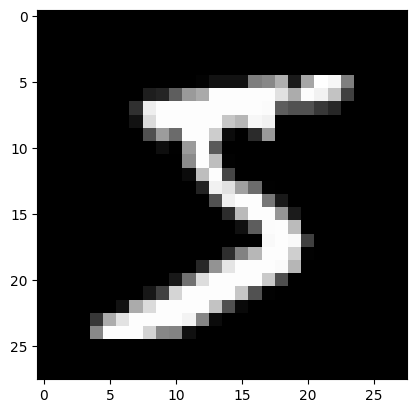

In [5]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()

In [6]:
train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
valid_dataset = TensorDataset(torch.tensor(x_valid), torch.tensor(y_valid))

Definio el tamaño del batch

In [7]:
batch_size=32

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
n_batches_train = len(train_dataloader) // batch_size
n_batches_valid = (len(valid_dataloader) + batch_size - 1) // batch_size

print(f"Batch en train: {n_batches_train}")
print(f"Batch en valid: {n_batches_valid}")

Batch en train: 48
Batch en valid: 10


## Creación de la red
### Definición de la red
Red creada para el ejercicio 1, debajo se creara una red utilizando <strong><u>nn.Modulezz</strong></u>

In [10]:
from torch import nn

class MyArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(28*28, 512)
        self.linear_layer_2 = nn.Linear(512, 512)
        self.linear_layer_3 = nn.Linear(512, 10)

    def forward(self, x):
        l1 = self.linear_layer_1(x)
        h1 = nn.ReLU()(l1)
        l2 = self.linear_layer_2(h1)
        h2 = nn.ReLU()(l2)
        l3 = self.linear_layer_3(h2)
        probs = nn.LogSoftmax(dim=-1)(l3)
        return probs

### Instanciación de la clase

In [11]:
model = MyArchitecture()

### Función de pérdida

Creación de la función de pérdida basada en la log-verosimilitud negativa

La función nn.NLLLoss() mide la diferencia entre las probabilidades predichas por el modelo y las etiquetas reales. Se utiliza generalmente en problemas de clasificación donde el modelo genera log-probabilidades como salida.

In [12]:
loss_func = nn.NLLLoss()

### Optimizador

Creacion del optimizador 

Especificamos el algoritmo de optimización <strong>Descenso de Gradiente Estocástico (SGD)</strong>. Este algoritmo ajusta los parámetros del modelo en la dirección del gradiente negativo para minimizar la función de pérdida.

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Funciones auxiliares

Creamos la funcion para medir la proporción de predicciones correctas sobre el total de predicciones realizadas.


In [14]:
def accuracy(probs, target):
    class_predictions = torch.argmax(probs, dim=1)
    return (class_predictions == target).float().mean()

## Training loop usando Pytorch:

In [15]:
n_epochs = 15

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0
    for x_train_batch, y_train_batch in train_dataloader:
        predictions = model(x_train_batch)
        loss = loss_func(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for x_valid_batch, y_valid_batch in valid_dataloader:
        predictions = model(x_valid_batch)
        loss = loss_func(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')

epoch 0 | train loss 69.60032799243928 | validation loss 2.266744940081088 | accuracy 15.075
epoch 1 | train loss 64.33877675533294 | validation loss 2.155635650159454 | accuracy 20.728125
epoch 2 | train loss 52.25359833240509 | validation loss 1.8938421068173223 | accuracy 23.04375
epoch 3 | train loss 36.07976271510124 | validation loss 1.4246342399908958 | accuracy 24.584375
epoch 4 | train loss 25.84026345908642 | validation loss 1.0041963160610017 | accuracy 25.89375
epoch 5 | train loss 20.448411978781223 | validation loss 0.7706560425779717 | accuracy 26.615625
epoch 6 | train loss 17.36172891408205 | validation loss 0.6416000033790151 | accuracy 27.034375
epoch 7 | train loss 15.371255046129226 | validation loss 0.562311693882988 | accuracy 27.403125
epoch 8 | train loss 14.063795322179795 | validation loss 0.5090723034287598 | accuracy 27.584375
epoch 9 | train loss 13.0598363943398 | validation loss 0.4707795422064213 | accuracy 27.84375
epoch 10 | train loss 12.330541007220

## Resolucion de los puntos

### 1
Calcule la matriz de confusión para los dígitos. La matriz de confusión es una métrica, por lo que debe ser calculada sólo en validación.

Para este punto nos ayudamos de la libreria sklearn


In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
model.eval()  # Modo evaluación

all_preds = []
all_targets = []

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for x_valid_batch, y_valid_batch in valid_dataloader:
        # forward pass
        predictions = model(x_valid_batch)
        # argmax para obtener la clase predicha (0..9 en MNIST)
        pred_labels = predictions.argmax(dim=1)
        
        # Guardamos en listas (o tensores) para luego generar la matriz de confusión
        all_preds.append(pred_labels.cpu().numpy())  
        all_targets.append(y_valid_batch.cpu().numpy())
        for i in range(len(pred_labels)):
            if pred_labels[i] != y_valid_batch[i]:
                misclassified_images.append(x_valid_batch[i])
                misclassified_preds.append(pred_labels[i].item())
                misclassified_labels.append(y_valid_batch[i].item())

# Unimos todos los arreglos a lo largo de la primera dimensión
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)


In [61]:
cm = confusion_matrix(all_targets, all_preds)
print("Matriz de confusión:\n", cm)


Matriz de confusión:
 [[ 951    0    7    6    0    6    6    3   12    0]
 [   0 1031    3    8    1    3    2    2   14    0]
 [   7   16  874   14   14    4   22   12   22    5]
 [   3    4   26  895    0   57    4    6   22   13]
 [   3    9    3    1  910    2    6    2    4   43]
 [  13    8   13   52   13  759   22    6   18   11]
 [   6    2   14    1   12    8  921    0    3    0]
 [  14   12   14    2    9    2    0 1011    1   25]
 [   5   29   21   35    3   23    4    7  861   21]
 [   6    5    8   12   37    7    0   44    4  838]]


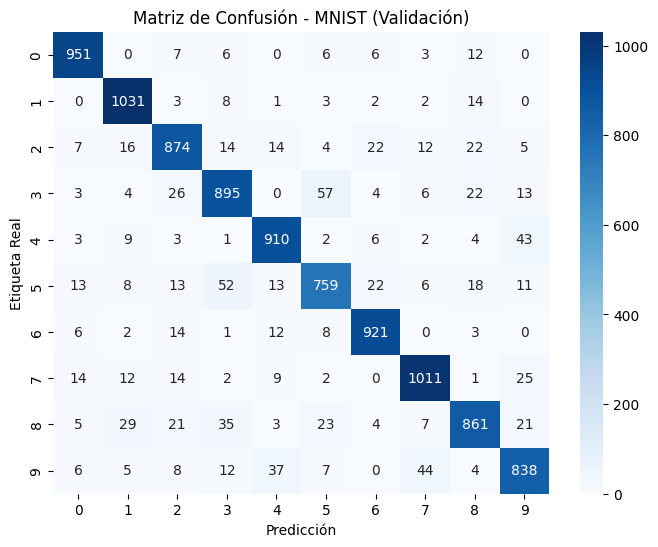

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión - MNIST (Validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


<strong> Interpretacion: </strong> En la diagonal principal se ven los numero mas grandes, eso es bueno ya que indica que son aciertos. 
Luego vemos valores altos como por ejemplo un 43 en la fila 4, columna 9. Aca podemos decir que esta interpretando un nueve (9) cuando en realidad es un cuatro (4).
Una situacio parecida sucede con el tres (3) y el cinco (5) donde se observan 57 errores de predicción.

### 2
Utilizando la matriz de confusión elegir el par de dígitos dónde el modelo se confunde más y mostrar 20 ejemplos mal clasificados.

Para poder resolver este punto desactivamos la `shuffle=True` del Dataloader `valid_dataloader`

Para simplificar vamos a mostrar unicamente los primer 16 ejemplos

Poner en `nro_target` el numero esperado, automaticamente se buscaran los mal clasificados.

In [54]:
# all_targets: contiene las etiquetas reales
# all_preds:   contiene las predicciones del modelo


nro_target = 1
misclassified_3_indices = np.where((all_targets == nro_target) & (all_preds != nro_target))[0]

print("Índices de los ejemplos de 3 mal clasificados:", misclassified_3_indices)

# Puedes ver cuántos son
print(f"Total de '3' mal clasificados: {len(misclassified_3_indices)}")

# Para inspeccionar cuáles fueron las predicciones en esos casos
print("Predicciones en esos índices:", all_preds[misclassified_3_indices])


Índices de los ejemplos de 3 mal clasificados: [ 120  396  572  632 1432 1544 2097 2107 2167 2392 2624 2738 3098 3168
 3330 4070 4388 4506 5310 5505 5870 6208 6576 6717 6737 6836 8072 9339
 9354 9382 9783 9912 9919]
Total de '3' mal clasificados: 33
Predicciones en esos índices: [4 6 7 3 5 8 8 8 8 3 8 2 8 3 8 8 8 2 3 8 2 3 7 3 8 5 6 5 3 3 8 8 8]


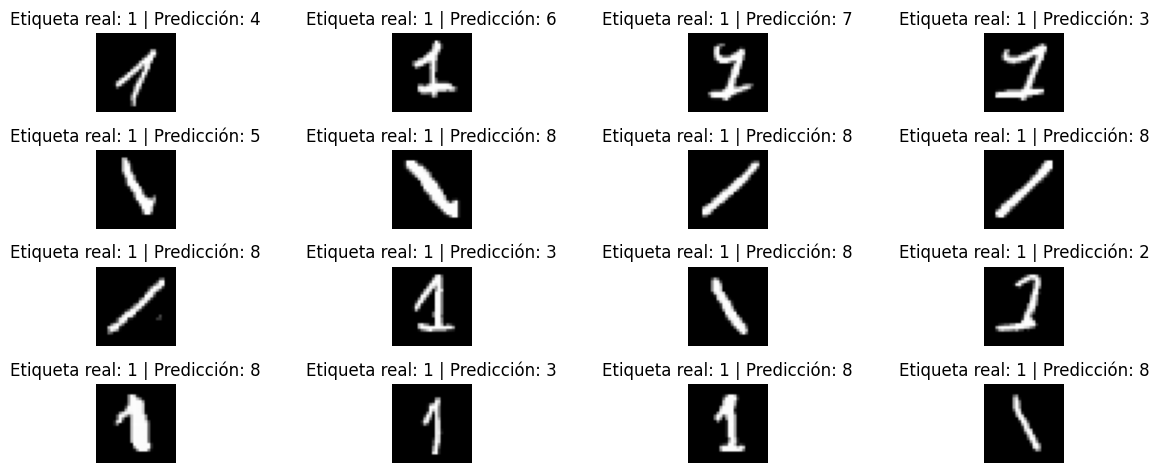

In [55]:
num_to_show = 16 #len(misclassified_3_indices)
plt.figure(figsize=(12, 6))
for idx in range(num_to_show):
    plt.subplot((num_to_show//4) + 1, 4, idx + 1)
    index = misclassified_3_indices[idx]
    image = x_valid[index].reshape((28, 28))
    plt.imshow(image.reshape((28, 28)), cmap='gray')
    pyplot.title(f"Etiqueta real: {y_valid[index]} | Predicción: {all_preds[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### 3
Una función que muestre los 20 ejemplos de validación con mayor costo. Intuitivamente estos son los ejemplos donde el modelo está más errado: arroja probabilidades altas para clases que no son la correcta.


In [86]:
import torch
import torch.nn.functional as F

def top_20_loss(model, dataloader, device, largest=True):
    model.eval()  # Establece el modelo en modo evaluación
    losses = []
    examples = []

    with torch.no_grad():  # No se calculan gradientes durante la evaluación
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Predicciones del modelo
            outputs = model(x_batch)
            
            # Calcula la pérdida para cada ejemplo
            batch_losses = F.cross_entropy(outputs, y_batch, reduction='none')  # Sin reducir
            losses.extend(batch_losses.cpu().numpy())  # Guardamos las pérdidas
            examples.extend(zip(x_batch.cpu().numpy(), y_batch.cpu().numpy(), outputs.cpu().numpy()))  # Datos originales y predicciones

    # Ordena las pérdidas en orden descendente
    losses = torch.tensor(losses)
    #top_20_indices = losses.topk(20).indices  # Índices de los 20 mayores errores
    top_20_indices = losses.topk(20, largest=largest).indices  

    # Muestra los resultados
    print(f"Top 20 ejemplos con {'mayor' if largest else 'menor'} pérdida:")
    for nro, idx in enumerate(top_20_indices):
        x, y_true, y_pred = examples[idx]
        print(f"Ejemplo {nro}: Indice {idx} - Pérdida = {losses[idx]:.4f}")
        print(f" - Etiqueta real: {y_true}")
        print(f" - Predicción (probabilidades): {F.softmax(torch.tensor(y_pred), dim=-1).tolist()}\n")

In [87]:
top_20_loss(model, valid_dataloader, device='cpu', largest=True)

Top 20 ejemplos con mayor pérdida:
Ejemplo 0: Indice 9915 - Pérdida = 12.1114
 - Etiqueta real: 4
 - Predicción (probabilidades): [7.769345393171534e-05, 7.201209882623516e-06, 0.0007755683618597686, 0.0001715094258543104, 5.496482572198147e-06, 3.329573883092962e-05, 2.5296480998804327e-07, 0.9945592284202576, 0.00020059573580510914, 0.004169082269072533]

Ejemplo 1: Indice 3216 - Pérdida = 10.2480
 - Etiqueta real: 9
 - Predicción (probabilidades): [0.937472403049469, 7.814417557483466e-08, 0.0005462676635943353, 0.0008931170450523496, 6.86497241986217e-06, 0.06008664146065712, 0.00038339418824762106, 2.529754965507891e-05, 0.0005504573346115649, 3.5428369301371276e-05]

Ejemplo 2: Indice 5739 - Pérdida = 9.9832
 - Etiqueta real: 5
 - Predicción (probabilidades): [0.0026199989952147007, 3.1052960025590437e-07, 0.896938681602478, 0.00023902376415207982, 1.7994405425270088e-05, 4.617109880200587e-05, 0.10007037222385406, 3.1603835850546602e-06, 6.040655352990143e-05, 3.895878307957901e


### 4
Una función que muestre los 20 ejemplos de validación donde el modelo arroja probabilidades más bajas. Esto se puede interpretar como que el modelo está "poco seguro" para estos casos.

In [88]:
top_20_loss(model, valid_dataloader, device='cpu', largest=False)

Top 20 ejemplos con menor pérdida:
Ejemplo 0: Indice 6069 - Pérdida = 0.0000
 - Etiqueta real: 2
 - Predicción (probabilidades): [3.42191555091631e-07, 3.8181052763874845e-10, 0.9999880790710449, 1.0388490409241058e-05, 7.044997918370655e-11, 2.220884809389645e-09, 7.779941029184556e-07, 4.667087272203219e-10, 3.175999268023588e-07, 3.329359288262168e-10]

Ejemplo 1: Indice 5655 - Pérdida = 0.0000
 - Etiqueta real: 2
 - Predicción (probabilidades): [7.813048874538708e-09, 1.3904436002576404e-07, 0.9999679327011108, 2.5944154913304374e-05, 6.483714953819941e-11, 4.585194002260096e-09, 2.985890432682936e-06, 2.0175855430792922e-10, 2.99271528092504e-06, 3.065105391719669e-10]

Ejemplo 2: Indice 1216 - Pérdida = 0.0000
 - Etiqueta real: 2
 - Predicción (probabilidades): [8.375585025532928e-07, 6.680174746698242e-10, 0.99996018409729, 8.75655678100884e-06, 2.0028132485805372e-09, 1.3390695663417773e-08, 2.8398393624229357e-05, 2.194708477454288e-11, 1.7914904901772388e-06, 4.28816593345260